In [1]:
import os
from pathlib import Path
from collections import Counter

import anndata
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pollock
from pollock.models.model import PollockDataset, PollockModel, load_from_directory

In [2]:
# !pip install -e /pollock

In [3]:
# %load_ext autoreload
# %autoreload 2

## collect data for module training

In [4]:
data_map = {
    'aml': '/data/single_cell_classification/tumor/aml',
    'br': '/data/single_cell_classification/tumor/BR/raw/houxiang_brca/merged.h5ad',
    'ccrcc': '/data/single_cell_classification/tumor/CCRCC/yige/adata.h5ad',
    'cesc': '/data/single_cell_classification/tumor/CESC/cesc.h5ad',
    'gbm': '/data/single_cell_classification/tumor/gbm/gbm.h5ad',
    'hnscc': '/data/single_cell_classification/tumor/HNSC/processed.h5ad',
    'melanoma': '/data/single_cell_classification/tumor/melanoma/melanoma.h5ad',
    'myeloma': '/data/single_cell_classification/tumor/myeloma/processed.h5ad',
    'pdac': '/data/single_cell_classification/tumor/PDAC/pdac.h5ad',
    'pdac_caf': '/data/single_cell_classification/tumor/PDAC/pdac_caf_subtypes.h5ad'
}

In [ ]:
# adata_map = {}
# for k, fp in data_map.items():
#     print(k)
#     try:
#         adata_map[k] = sc.read_h5ad(fp)
#     except OSError:
#         print(f'{k} failed')

In [ ]:
# ## check for cell_type key
# for k, adata in adata_map.items(): print(k, 'cell_type' in adata.obs.columns)

## iterate through and train modules

## 3. train pollock module

specify a location to save the trained pollock module

In [19]:
module_type = 'pdac_caf'
run_name = f'{module_type}_v0.1.0'

In [20]:
module_save_filepath = f'/models/modules/{run_name}'
Path(module_save_filepath).mkdir(parents=True, exist_ok=True)

here we create a new anndata object from our processed anndata object

scanpy expects the raw counts data to be in the X attribute

In [21]:
train_adata = sc.read_h5ad(data_map[module_type])
train_adata

AnnData object with n_obs × n_vars = 38502 × 25282
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'sample', 'treatment', 'tissue', 'fibroblast_subtype', 'ident', 'sample_id'
    var: 'sct.detection_rate', 'sct.gmean', 'sct.variance', 'sct.residual_mean', 'sct.residual_variance', 'sct.variable'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [22]:
train_adata = train_adata[train_adata.obs['cell_type']!= 'Unknown']
train_adata

View of AnnData object with n_obs × n_vars = 38502 × 25282
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'sample', 'treatment', 'tissue', 'fibroblast_subtype', 'ident', 'sample_id'
    var: 'sct.detection_rate', 'sct.gmean', 'sct.variance', 'sct.residual_mean', 'sct.residual_variance', 'sct.variable'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

take a look at our cell counts

In [24]:
Counter(train_adata.obs['cell_type']).most_common()

[('iCAF', 28907),
 ('myCAF', 6826),
 ('CXCL4+_iCAF', 1294),
 ('apCAF', 1073),
 ('CD133+_iCAF', 402)]

initialize PollockDataset

In [25]:
pds = PollockDataset(train_adata, cell_type_key='cell_type', n_per_cell_type=500,
                    dataset_type='training')

2020-06-10 23:05:20,173 normalizing counts for model training
/miniconda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-06-10 23:05:23,305 scaling data
2020-06-10 23:05:30,444 creating tf datasets


In [26]:
pm = PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.0001, latent_dim=25)

In [27]:
pm.fit(pds, epochs=40, max_metric_batches=2, metric_epoch_interval=1,
      metric_n_per_cell_type=50)

2020-06-10 23:06:03,047 epoch: 1, train loss: 140.4657745361328, val loss: 152.52899169921875
2020-06-10 23:06:08,021 epoch: 2, train loss: 138.24290466308594, val loss: 150.66162109375
2020-06-10 23:06:13,015 epoch: 3, train loss: 134.78277587890625, val loss: 147.72610473632812
2020-06-10 23:06:18,061 epoch: 4, train loss: 131.6588897705078, val loss: 144.77444458007812
2020-06-10 23:06:23,108 epoch: 5, train loss: 129.87875366210938, val loss: 143.50660705566406
2020-06-10 23:06:27,962 epoch: 6, train loss: 127.88604736328125, val loss: 141.18280029296875
2020-06-10 23:06:32,968 epoch: 7, train loss: 126.4998550415039, val loss: 139.91168212890625
2020-06-10 23:06:37,863 epoch: 8, train loss: 125.52465057373047, val loss: 139.01107788085938
2020-06-10 23:06:43,091 epoch: 9, train loss: 125.00911712646484, val loss: 138.182373046875
2020-06-10 23:06:48,031 epoch: 10, train loss: 124.39488983154297, val loss: 137.6202392578125
2020-06-10 23:06:53,036 epoch: 11, train loss: 123.7205200

In [28]:
pm.save(pds, module_save_filepath)

## 4. module performance

visualize the overlap between groundtruth vs predicted cell types

Text(32.09375, 0.5, 'Groundtruth')

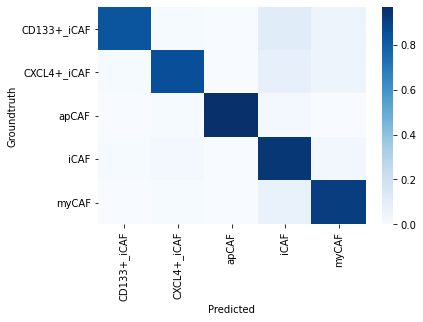

In [29]:
confusion_matrix = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
sns.heatmap(confusion_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Groundtruth')

plot loss and accuracy for training and validation sets during training

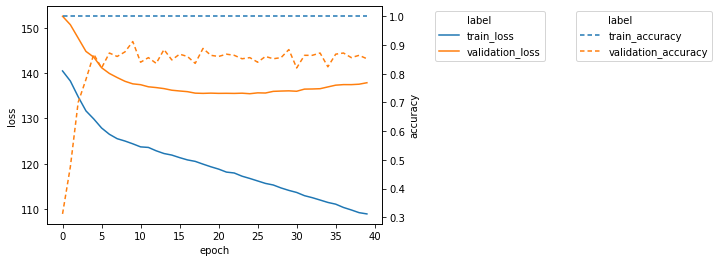

In [30]:
loss, label, epoch = [], [], []
for k in ['train_loss', 'validation_loss']:
    loss += pm.summary['history'][k]
    label += [k] * len(pm.summary['history'][k])
    epoch += list(range(len(pm.summary['history'][k])))
df = pd.DataFrame.from_dict({'label': label, 'loss': loss, 'epoch': epoch})

sns.lineplot(x='epoch', y='loss', data=df, hue='label')
plt.legend(bbox_to_anchor=(1.5, 1))

accuracy, label = [], []
for k in ['train_accuracy', 'validation_accuracy']:
    accuracy += pm.summary['history'][k]
    label += [k] * len(pm.summary['history'][k])
df = pd.DataFrame.from_dict({'label': label, 'accuracy': accuracy, 'epoch': epoch})

ax2 = plt.twinx()
sns.lineplot(x='epoch', y='accuracy', data=df, hue='label', ax=ax2, style='label',
                 dashes=[(3,2), (3,2)])
plt.legend(bbox_to_anchor=(2., 1))

plot validation loss broken down by cell type

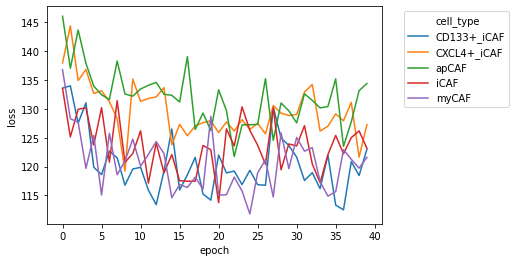

In [31]:
loss, label, epoch = [], [], []
for k in ['cell_type_val_loss']:
    for cell_type, vals in pm.summary['history'][k].items():
        loss += vals
        label += [cell_type] * len(vals)
        epoch += list(range(len(vals)))
    
df = pd.DataFrame.from_dict({
    'cell_type': label,
    'loss': loss,
    'epoch': epoch
})

sns.lineplot(x='epoch', y='loss', data=df, hue='cell_type')
plt.legend(bbox_to_anchor=(1.05, 1))

plot validation accuracy for each cell type during training

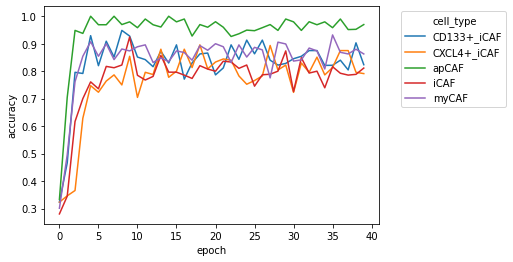

In [32]:
loss, label, epoch = [], [], []
for k in ['cell_type_val_f1']:
    for cell_type, vals in pm.summary['history'][k].items():
        loss += vals
        label += [cell_type] * len(vals)
        epoch += list(range(len(vals)))
    
df = pd.DataFrame.from_dict({
    'cell_type': label,
    'accuracy': loss,
    'epoch': epoch
})

sns.lineplot(x='epoch', y='accuracy', data=df, hue='cell_type')
plt.legend(bbox_to_anchor=(1.05, 1))

## 5. retrain module for optimal number of epochs

from the above plots it apperas that the optimal training time is ~45 epochs for this dataset

In [33]:
pm = PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.0001, latent_dim=25)

In [ ]:
pm.fit(pds, epochs=21, max_metric_batches=5, metric_epoch_interval=1,
      metric_n_per_cell_type=50)

2020-06-10 23:10:09,597 epoch: 1, train loss: 140.59030151367188, val loss: 151.86207580566406
2020-06-10 23:10:14,630 epoch: 2, train loss: 138.33721923828125, val loss: 150.39657592773438
2020-06-10 23:10:19,773 epoch: 3, train loss: 135.26055908203125, val loss: 147.06326293945312
2020-06-10 23:10:24,976 epoch: 4, train loss: 132.11439514160156, val loss: 145.13961791992188
2020-06-10 23:10:30,024 epoch: 5, train loss: 129.32749938964844, val loss: 143.2340545654297
2020-06-10 23:10:35,229 epoch: 6, train loss: 127.7431869506836, val loss: 141.79776000976562
2020-06-10 23:10:40,197 epoch: 7, train loss: 126.49295043945312, val loss: 139.72531127929688
2020-06-10 23:10:45,144 epoch: 8, train loss: 125.82903289794922, val loss: 138.56471252441406
2020-06-10 23:10:50,321 epoch: 9, train loss: 124.85945129394531, val loss: 137.9020233154297
2020-06-10 23:10:55,392 epoch: 10, train loss: 124.5362777709961, val loss: 137.27420043945312
2020-06-10 23:11:00,568 epoch: 11, train loss: 123.85

In [ ]:
pm.save(pds, module_save_filepath)

In [ ]:
confusion_matrix = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
sns.heatmap(confusion_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Groundtruth')

In [ ]:
loss, label, epoch = [], [], []
for k in ['train_loss', 'validation_loss']:
    loss += pm.summary['history'][k]
    label += [k] * len(pm.summary['history'][k])
    epoch += list(range(len(pm.summary['history'][k])))
df = pd.DataFrame.from_dict({'label': label, 'loss': loss, 'epoch': epoch})

sns.lineplot(x='epoch', y='loss', data=df, hue='label')
plt.legend(bbox_to_anchor=(1.5, 1))

accuracy, label = [], []
for k in ['train_accuracy', 'validation_accuracy']:
    accuracy += pm.summary['history'][k]
    label += [k] * len(pm.summary['history'][k])
df = pd.DataFrame.from_dict({'label': label, 'accuracy': accuracy, 'epoch': epoch})

ax2 = plt.twinx()
sns.lineplot(x='epoch', y='accuracy', data=df, hue='label', ax=ax2, style='label',
                 dashes=[(3,2), (3,2)])
plt.legend(bbox_to_anchor=(2., 1))

In [ ]:
loss, label, epoch = [], [], []
for k in ['cell_type_val_loss']:
    for cell_type, vals in pm.summary['history'][k].items():
        loss += vals
        label += [cell_type] * len(vals)
        epoch += list(range(len(vals)))
    
df = pd.DataFrame.from_dict({
    'cell_type': label,
    'loss': loss,
    'epoch': epoch
})

sns.lineplot(x='epoch', y='loss', data=df, hue='cell_type')
plt.legend(bbox_to_anchor=(1.05, 1))

In [ ]:
loss, label, epoch = [], [], []
for k in ['cell_type_val_f1']:
    for cell_type, vals in pm.summary['history'][k].items():
        loss += vals
        label += [cell_type] * len(vals)
        epoch += list(range(len(vals)))
    
df = pd.DataFrame.from_dict({
    'cell_type': label,
    'accuracy': loss,
    'epoch': epoch
})

sns.lineplot(x='epoch', y='accuracy', data=df, hue='cell_type')
plt.legend(bbox_to_anchor=(1.05, 1))

In [ ]:
train_adata = sc.read_h5ad(data_map[module_type])

In [ ]:
loaded_pds, loaded_pm = load_from_directory(train_adata, module_save_filepath, )

In [ ]:
labels, probs, cell_type_probs = loaded_pm.predict_pollock_dataset(loaded_pds, labels=True, )
labels[:5], probs[:5]

In [ ]:
train_adata.obs['annotated_cell_type'] = train_adata.obs['cell_type'].to_list()
train_adata.obs['predicted_cell_type'] = list(labels)
train_adata.obs['predicted_probablility'] = list(probs)

In [ ]:
cell_embeddings = loaded_pm.get_cell_embeddings(loaded_pds.prediction_ds)
cell_embeddings.shape, cell_embeddings

In [ ]:
train_adata.obsm['cell_embeddings'] = cell_embeddings
sc.pp.neighbors(train_adata, use_rep='cell_embeddings')
sc.tl.umap(train_adata)

In [ ]:
sc.pl.umap(train_adata, color=['annotated_cell_type', 'predicted_cell_type', 'predicted_probablility'],
          frameon=False, ncols=1)